# Imports and other setup

In [1]:
# data processing
import pandas as pd
import numpy as np
from numpy import genfromtxt

# graphs / figures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx

# sklearn / models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# nltk
import nltk
from nltk.corpus import stopwords

# others
import os
import sys
sys.path.append('../')
from embedding_functions_hugo.embedding_functions import *
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from happytransformer import HappyTextClassification

def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [ ]:
# df_politics = pd.read_csv('../data/28feb/scrapes/politics.csv')

### Function for getting post_title, post_author, post_id, and the embedded title texts

In [2]:
def do_post_titles(df):
    texts, authors, post_ids = [], [], []
    title_author_set = set(zip(df['post_title'], df['post_author'], df['post_id']))

    for text, author, post_id in  title_author_set:
        texts.append(text)
        authors.append(author)
        post_ids.append(post_id)
    
    title_embeddings = embed_comments(texts)
    return pd.DataFrame(data=[post_ids, authors, texts, title_embeddings]).T.rename(columns={0 : 'post_id', 1: 'post_author', 2: 'post_title', 3: 'embeddings'})

In [3]:
# politics_data = do_post_titles(df_politics)
# politics_data.to_csv('../data/28feb/title_author_id_emb/politics.csv')

# politics_data = pd.read_csv('../data/28feb/title_author_id_emb/politics.csv')

### Peeking at title embeddings

In [4]:
# politics_data.head()

In [5]:
# plt.figure(1, figsize=(12,9))

# reduce_dims_and_kmeans(dict(politics_data['embeddings']), 2)

### Getting final dataframe that we can use

In [6]:
def shorten_comment_text(df):
    '''Takes dataframe as input, shortens comment text, creates short_text column and removes comment_text column'''
    
    # getting all commenters that have also made a post
    shortened_df = df.query('comment_author in post_author').copy()

    # cleaning their comments and saving to new column
    clean_text = prep_pipeline(shortened_df, 'comment_text', loud=False)
    shortened_df['short_text'] = shorten_sens(clean_text, 50)
    shortened_df.drop('comment_text', axis=1, inplace=True)

    return shortened_df

In [7]:
def get_embed_pairs(df):
   '''Takes dataframe as input, combines all user title texts into one
      Returns embed_pairs'''
    
   # for each poster, appending all of their post text into one long string
   embed_pairs = {}
   for text, author in zip(df['post_title'], df['post_author']):
      if author not in embed_pairs.keys():
         embed_pairs[author] = text
      else:
         embed_pairs[author] += ' '+text

   return embed_pairs

def get_title_embeds(embed_pairs):
   '''Takes embed_pairs as input. Embeds the post titles and returns an array of them.'''

   # embedding all post titles and reducing them to 1 dimension
   embeds = dict(zip(embed_pairs.keys(), embed_comments(list(embed_pairs.values()))))
   embeds = reduce_to_one_dimension_kmeans(embeds)[-1]

   return embeds

# Creating Network

In [8]:
def create_network(df):
    '''Takes dataframe as input, creates a directed networkx network and returns it'''

    # Initializing text classification model
    model = HappyTextClassification(model_type='DISTILBERT', model_name='distilbert-base-uncased-finetuned-sst-2-english', num_labels=2)

    # initializing networkx directed graph
    G = nx.DiGraph()

    # combining users title texts into one
    embed_pairs = get_embed_pairs(df)

    # embedding those combined title texts
    embeds = get_title_embeds(embed_pairs)

    # adding each post author as a node to network, with their 1 dimensional title embeddings as an attribute (named polarity)
    for i, j in zip(embed_pairs.keys(), embeds):
        G.add_node(i, polarity = int(j))

    # getting list of user pairs for comments left on posts
    pairings = list(zip(df['comment_author'], df['post_author']))

    # classifying sentiments of comment texts and saving them in list "polarities"
    polarities = []
    for comment in df['short_text']:
        polarities.append(model.classify_text(comment).score)

    # adding edges to graph, where each edge is a comment left by user a to user b, and its attribute is the sentiment of the comment
    for pair, polarity in zip(pairings, polarities):
        # avoiding self edge connections
        if pair[0] != pair[1]:
            G.add_edge(u_of_edge=pair[0], v_of_edge=pair[1], attr=polarity)

    # drawing network
    nx.draw(G)

    return G

## Creating, initially inspecting and saving subreddits

Example filepath: '../data/19march/graphs/politics_network.gexf'

Make sure the filepath exists before running (manually create them) as otherwise it will take ~12 mins to run and end up giving an error

### r/politics - takes ~11 mins with 19march politics

03/19/2023 17:21:53 - INFO - happytransformer.happy_transformer -   Using model: cpu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 3/3 [06:44<00:00, 134.77s/it]
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


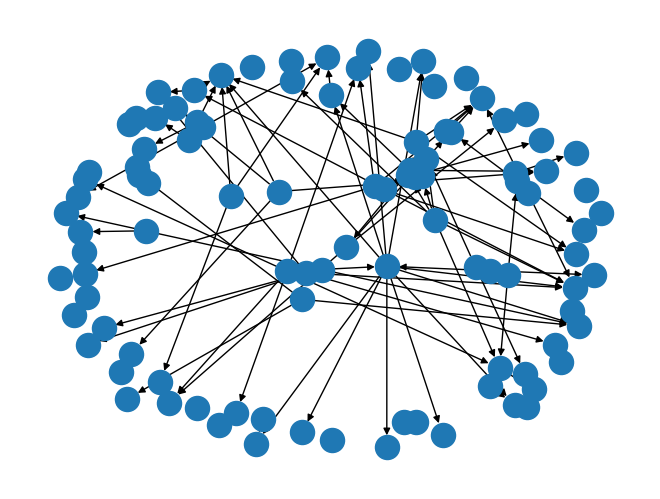

In [10]:
# grabbing scraped df
df_politics = pd.read_csv('../data/19march/scrapes/politics.csv')

# doing pre-network stuff
df_politics_shortened = shorten_comment_text(df_politics)

# creating and drawing network
G_politics = create_network(df_politics_shortened)

# saving network
nx.write_gexf(G_politics, '../data/19march/graphs/politics_network.gexf')

### r/gaming

03/19/2023 18:47:33 - INFO - happytransformer.happy_transformer -   Using model: cpu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 3/3 [04:30<00:00, 90.02s/it] 
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


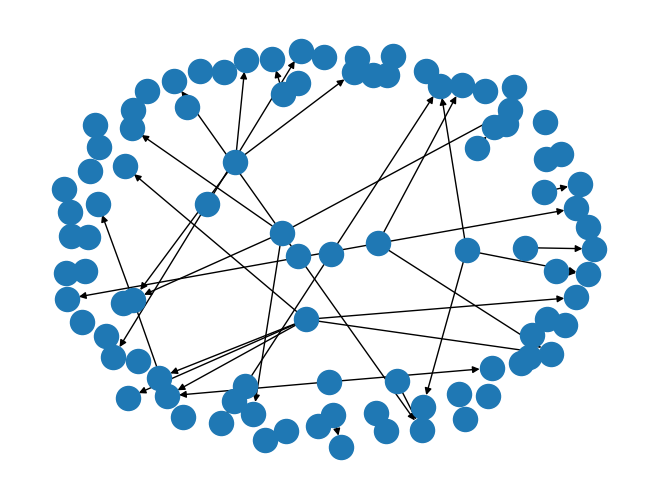

In [11]:
# grabbing scraped df
df_gaming = pd.read_csv('../data/19march/scrapes/gaming.csv')

# doing pre-network stuff
df_gaming_shortened = shorten_comment_text(df_gaming)

# creating and drawing network
G_gaming = create_network(df_gaming_shortened)

# saving network
nx.write_gexf(G_gaming, '../data/19march/graphs/gaming_network.gexf')

### r/EscapefromTarkov

03/19/2023 23:22:09 - INFO - happytransformer.happy_transformer -   Using model: cpu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 5/5 [10:11<00:00, 122.21s/it]
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


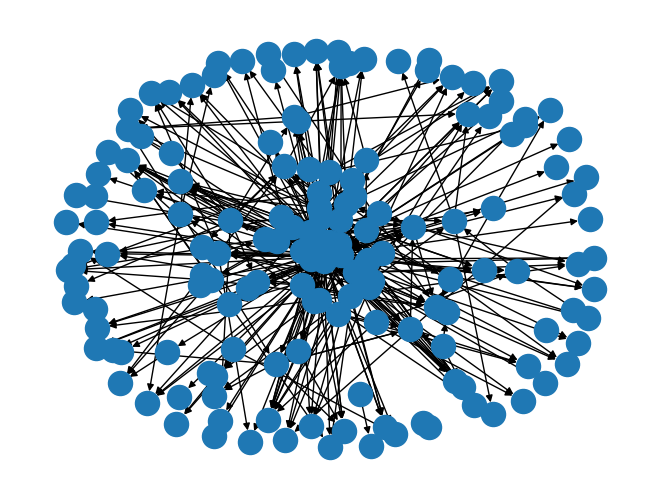

In [15]:
# grabbing scraped df
df_tarkov = pd.read_csv('../data/19march/scrapes/EscapefromTarkov.csv')

# doing pre-network stuff
df_tarkov_shortened = shorten_comment_text(df_tarkov)

# creating and drawing network
G_tarkov = create_network(df_tarkov_shortened)

# saving network
nx.write_gexf(G_tarkov, '../data/19march/graphs/tarkov_network.gexf')

03/19/2023 19:48:25 - INFO - happytransformer.happy_transformer -   Using model: cpu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 2/2 [01:25<00:00, 42.87s/it]
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


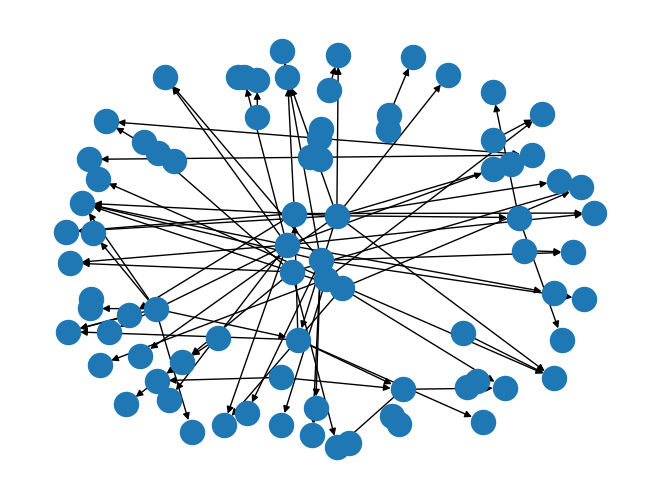

In [12]:
# grabbing scraped df
df_okbuddyretard = pd.read_csv('../data/19march/scrapes/okbuddyretard.csv')

# doing pre-network stuff
df_okbuddyretard_shortened = shorten_comment_text(df_okbuddyretard)

# creating and drawing network
G_okbuddyretard = create_network(df_okbuddyretard_shortened)

# saving network
nx.write_gexf(G_okbuddyretard, '../data/19march/graphs/okbuddyretard_network.gexf')

03/19/2023 20:03:38 - INFO - happytransformer.happy_transformer -   Using model: cpu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Batches: 100%|██████████| 4/4 [07:28<00:00, 112.14s/it]
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\reddit_scraping\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


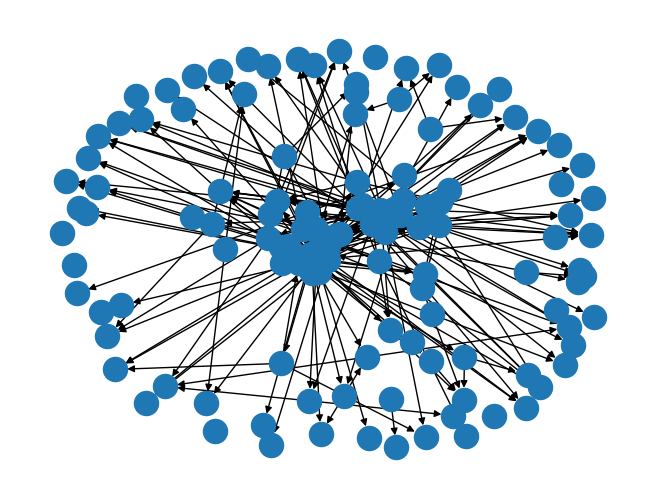

In [13]:
# grabbing scraped df
df_HuntShowdown = pd.read_csv('../data/19march/scrapes/HuntShowdown.csv')

# doing pre-network stuff
df_HuntShowdown_shortened = shorten_comment_text(df_HuntShowdown)

# creating and drawing network
G_HuntShowdown = create_network(df_HuntShowdown_shortened)

# saving network
nx.write_gexf(G_HuntShowdown, '../data/19march/graphs/HuntShowdown_network.gexf')